# Домашнее задание

### ИАД. 2024-2025

### Прогнозирование временных рядов

Мы постарались составить домашнее задание так, чтобы оно помогло закрепить все то, что мы прошли за 2 недели на лекциях и семинарах. Вы вольны использовать любые библиотеки, которые вам нравятся. Главное — это осознанность в выборе методов и интерпретации выводов.

В рамках домашнего задания будем работать с датасетом `NN5`, который можно скачать [здесь](https://zenodo.org/records/4656117). Временные ряды в этом датасете представляют собой данные по ежедневным снятиям наличных в банкоматах в Великобритании.

### Задание 1. Первичный анализ данных (1 балл)

In [1]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.3 MB/s eta 0:00:00


In [2]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from statsforecast import StatsForecast, models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [3]:
def mase(
    forecast: np.ndarray,
    insample: np.ndarray,
    outsample: np.ndarray,
    frequency: int,
) -> np.ndarray:
    """MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    Args:
        forecast: Forecast values. Shape: batch, time_o
        insample: Insample values. Shape: batch, time_i
        outsample: Target values. Shape: batch, time_o
        frequency: Frequency value
    Returns:
        Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(forecast - outsample)) / np.mean(
        np.abs(insample[:-frequency] - insample[frequency:])
    )

Нам пригодятся уже знакомые функции с семинаров по чтению рядов в формате tsf. Напомню, что иногда временные ряды могут быть представлены в tsf формате. Это такая структура данных, которая позволяет хранить метаинформацию о временных рядах, а также пары "первая дата — все значения временного ряда".

Функции позволяют считать данные в tsf формате и перевести их в формат, которым мы можем пользоваться.

In [4]:
def convert_tsf_to_dataframe(
    full_file_path_and_name: str,
    replace_missing_vals_with: Any = "NaN",
    value_column_name: str = "series_value",
) -> tuple[pd.DataFrame, str, int, str, str]:
    """
    Конвертирует файл формата TSF в pandas DataFrame.

    Args:
        full_file_path_and_name: Путь к файлу формата TSF.
        replace_missing_vals_with: Значение для замены пропусков.
        value_column_name: Имя столбца для значений временных рядов.

    Returns:
        DataFrame с данными временных рядов.
        Частота данных.
        Прогнозируемый горизонт.
        Содержат ли данные пропуски.
        Равны ли длины временных рядов.

    """
    col_names = []
    col_types = []
    all_data = {}
    all_series = []
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    data_started = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            if line.startswith("@"):
                if line.startswith("@data"):
                    data_started = True
                    # Инициализируем словарь для данных атрибутов
                    for col in col_names:
                        all_data[col] = []
                else:
                    parts = line.split(" ")
                    if line.startswith("@attribute"):
                        col_names.append(parts[1])
                        col_types.append(parts[2])
                    elif line.startswith("@frequency"):
                        frequency = parts[1]
                    elif line.startswith("@horizon"):
                        forecast_horizon = int(parts[1])
                    elif line.startswith("@missing"):
                        contain_missing_values = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
                    elif line.startswith("@equallength"):
                        contain_equal_length = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
            elif not line.startswith("#") and data_started:
                parts = line.split(":")
                # Последняя часть содержит значения ряда
                series_vals = parts[-1].split(",")
                numeric_series = [
                    replace_missing_vals_with if val == "?" else float(val) for val in series_vals
                ]
                all_series.append(pd.Series(numeric_series).array)
                # Преобразуем и сохраняем значения атрибутов
                for i in range(len(col_names)):
                    if col_types[i] == "numeric":
                        all_data[col_names[i]].append(int(parts[i]))
                    elif col_types[i] == "string":
                        all_data[col_names[i]].append(parts[i])
                    elif col_types[i] == "date":
                        all_data[col_names[i]].append(
                            datetime.strptime(parts[i], "%Y-%m-%d %H-%M-%S")
                        )

    all_data[value_column_name] = all_series
    loaded_data = pd.DataFrame(all_data)
    return loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length


def date_to_daterange(x: pd.Series, freq: str) -> pd.Series:
    """
    Преобразует временные метки в диапазон дат.

    Args:
        x: Временные метки.
        freq: Частота.

    Returns:
        pd.Series с диапазоном дат.

    """
    return pd.Series(pd.date_range(start=x.iloc[0], periods=len(x), freq=freq))


def convert_tsf_to_multivariate_or_standard_format(
    tsf_data_path: str,
    target_column: str = "series_value",
    date_from_column: str = "start_timestamp",
    id_column: str = "series_name",
    # one from ["multivariate", "standard"]
    format: str = "multivariate",
) -> pd.DataFrame:
    """
    Преобразует данные формата TSF в формат pandas DataFrame:
        если format == "standard" -> датафрейм с колонками "id", "date" и "value"
        если format == "multivariate" -> pivot таблица c date в качестве индекса,
            id в качестве колонок и значениями из value_column_name

    Args:
        tsf_data_path: Путь к файлу формата TSF.
        target_column: Имя столбца с целевой переменной.
        date_from_column: Имя столбца с переменной дат.
        id_column: Имя столбца с идентификаторами временных рядов.
        format: Формат данных ("multivariate" или "standard").

    Returns:
        pd.DataFrame с данными в формате "id", "date" и "value".

    """
    FREQ_MAP = {
        "monthly": "MS",
        "10_minutes": "10min",
        "half_hourly": "30min",
        "minutely": "1min",
        "daily": "D",
        "weekly": "7D",
        "yearly": "YS",
        "quarterly": "QS",
        "hourly": "H",
    }

    tsf_df, freq = convert_tsf_to_dataframe(tsf_data_path)[:2]

    # Преобразуем списки в {target_column} в "длинный столбец" со значениями
    tsf_df = tsf_df.explode(target_column)
    # Заменим повторяющиеся значения даты в {date_column} на date_range
    tsf_df["date"] = (
        tsf_df.groupby(id_column, sort=False)[date_from_column]
        .apply(lambda x: date_to_daterange(x, FREQ_MAP[freq]))
        .values
    )
    tsf_df = tsf_df.drop(columns=date_from_column)
    # Переименуем колонки
    tsf_df = tsf_df.rename(columns={id_column: "id", target_column: "value"}).reset_index(
        drop=True
    )
    # Приведем {id_column} к численным значениям
    ids2num = dict(zip(tsf_df["id"].unique(), np.arange(tsf_df["id"].nunique())))
    tsf_df["id"] = tsf_df["id"].map(ids2num)

    if format == "standard":
        return tsf_df
    return pd.pivot_table(tsf_df, values="value", index="date", columns="id")

#### Задание 1.1: Загрузка данных (0 баллов)

Давайте скачаем датасет __NN5__ и загрузим его, воспользовавшись функцией `convert_tsf_to_multivariate_or_standard_format`.

In [5]:
!wget "https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1" -O nn5_daily_dataset_without_missing_values.zip
!unzip -o nn5_daily_dataset_without_missing_values.zip
!rm nn5_daily_dataset_without_missing_values.zip

--2025-05-22 10:40:33--  https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289779 (283K) [application/octet-stream]
Saving to: ‘nn5_daily_dataset_without_missing_values.zip’

nn5_daily_dataset_w 100%[===================>] 282.99K   344KB/s    in 0.8s    

2025-05-22 10:40:34 (344 KB/s) - ‘nn5_daily_dataset_without_missing_values.zip’ saved [289779/289779]

Archive:  nn5_daily_dataset_without_missing_values.zip
  inflating: nn5_daily_dataset_without_missing_values.tsf  


In [6]:
df = convert_tsf_to_multivariate_or_standard_format(
    "nn5_daily_dataset_without_missing_values.tsf", format="standard"
)
df.head()

id      value       date
0   0  13.407029 1996-03-18
1   0  14.725057 1996-03-19
2   0  20.564059 1996-03-20
3   0   34.70805 1996-03-21
4   0  26.629819 1996-03-22

#### Задание 1.2: Типы данных (0.3 балла)

Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, id — object, а значения временных рядов — float. Если это не так, то исправьте их.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87801 entries, 0 to 87800
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      87801 non-null  int64         
 1   value   87801 non-null  object        
 2   date    87801 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.0+ MB


In [8]:
df['id'] = df['id'].astype('object')

In [9]:
df['value'] = df['value'].astype('float')

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87801 entries, 0 to 87800
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      87801 non-null  object        
 1   value   87801 non-null  float64       
 2   date    87801 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.0+ MB


#### Задание 1.3: Пропуски (0.05 балла)

Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом.

In [12]:
print(df.isnull().sum())

id       0
value    0
date     0
dtype: int64


#### Задание 1.4: Визуальный анализ временных рядов (0.4 балла)

Постройте линейные графики временных рядов. По оси X отложите время, по оси Y — значения временного ряда.

Используйте Plotly, чтобы можно было отложить сразу все временные ряды на одном графике.

In [ ]:
fig = go.Figure()
for series_id in df['id'].unique():
    series_data = df[df['id'] == series_id]
    fig.add_trace(go.Scattergl(x = series_data['date'], y = series_data['value'],
                              mode = 'lines',
                              name = f'Series {series_id}'))

In [ ]:
fig.update_layout(
    title='Date/Value',
    xaxis_title='Date',
    yaxis_title='Value',
    hovermode='x unified'
)
fig.show()

In [ ]:
statistic, p_value, lags, critical_values = kpss(series_data["value"])
print(f"KPSS p-value: {p_value}")

KPSS p-value: 0.1


__Ответьте на следующие вопросы:__
- Какова частотность (frequency) данных?

**Frequency – ежедневная (значение на графике показано в 00:00)**

- Выровнены ли временные ряды?

**Временные ряды выровнены (ряды покрывают одинаковые отрезки), более того, это эксплицитно указано в задании ниже**

- Стационарны ли временные ряды? Если нет, то какие признаки нестационарности вы можете выделить?

**Нет, временные ряды не стационарны: визуальным признаками этого является флуктуация амплитуды и среднего уровня у рядов (например ряд 4, 7, 1 и др.). Однако на уровне значимости 0.05 мы не можем отвергнуть гипотезу о стационарности.**

- На какие группы можно разбить временные ряды по наличию общих признаков? Есть ли что-то, чем похожи все временные ряды?

**Ряды можно разделить на группы с высокой/низкой волатильностью (визуально заметно отличие дисперсий, например, ряда 12, 33 и 101), с разным средним и т.д.**

- Есть ли в рядах выбросы? Как вы можете это определить?

**Крупные выбросы можно определить «на глазок» на графике (например series 33 in Feb 12, 1998). С формальной точки зрения наличие выбросов можно, например, через Z-оценку...**


#### Задание 1.5: Выделение тестовой выборки (0.25 балла)

Выделите 10% данных для теста, а остальные 90% оставьте для обучения. Делайте это очень аккуратно, чтобы не нарушить временную и многомерную структуру данных!

Вспомните и напишите, в чем особенность выделения тестовой выборки в задаче прогнозирования временных рядов и в задаче прогнозирования __многомерных__ временных рядов.

**Тестовая выборка всегда должна находиться после обучающей выборки во времени. Каждый отдельный временной ряд в наборе должен быть разбит так, чтобы тестовая часть шла после тренировочной части этого конкретного ряда.**

Обратите внимание, что временные ряды выровнены, а значит, в отличие от семинара, пробегаться в цикле по каждому id не нужно. Подумайте, как можно сделать это более эффективно.

In [ ]:
#Я только потом вспомнил про горизонт. Для 3-4 заданий буду использовать его
new_df = df.sort_values(by = 'date').reset_index(drop = True)
df_test = new_df.tail(int(len(df) * 0.1))
df_train = new_df.head(int(len(df) * 0.9))

### Задание 2. Полный анализ одного временного ряда (4 баллов)

#### Задание 2.1: Визуальный анализ (0.5 балла)

Выделите из данных временной ряд с номером 92. Постройте его линейный график.

In [ ]:
series_92_train = df_train[df_train['id'] == 92]
fig_92 = go.Figure()
fig_92.add_trace(go.Scattergl(x = series_92_train['date'], y = series_92_train['value'],
                            mode = 'lines',
                            name = 'Series 92 (Train)'))
fig_92.update_layout(
    title='Date/Value for Series 92',
    xaxis_title='Date',
    yaxis_title='Value',
    hovermode='x unified'
)
fig_92.show()

Постройте графики автокорреляций (ACF) и частных автокорреляций (PACF) до 40-го лага для тренировочной выборки.



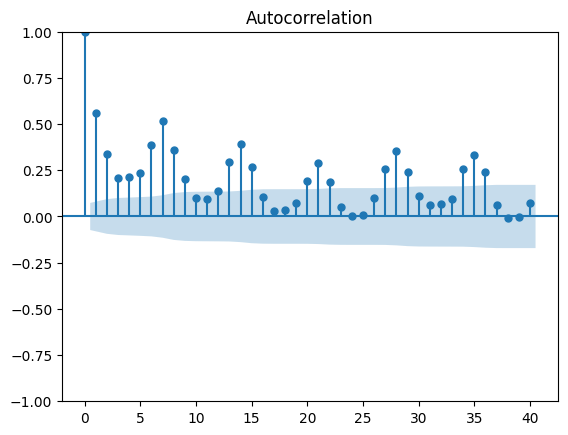

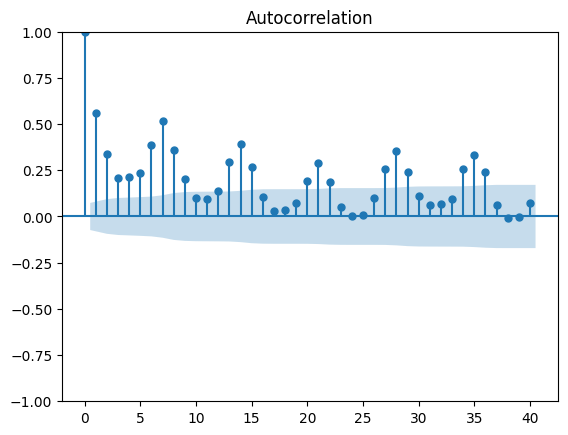

In [ ]:
plot_acf(series_92_train['value'], lags=40)

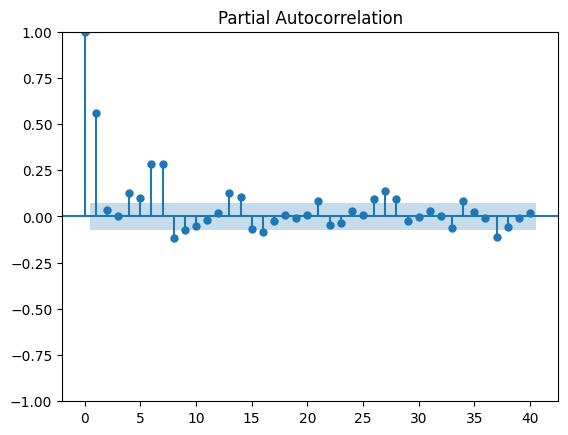

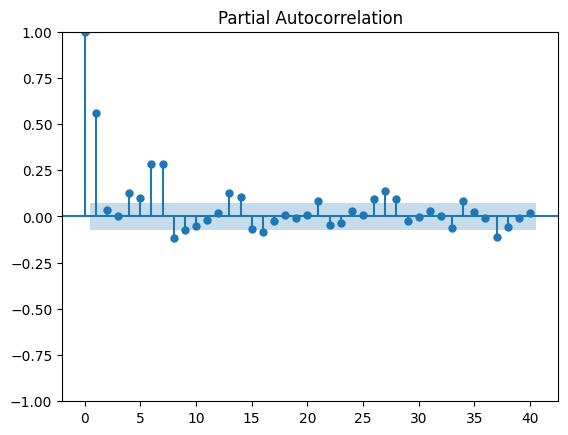

In [ ]:
plot_pacf(series_92_train['value'], lags=40)

In [ ]:
statistic, p_value, lags, critical_values = kpss(series_92_train["value"])
print(f"KPSS p-value: {p_value}")

KPSS p-value: 0.01


__Ответьте на следующие вопросы:__
- Стационарен ли временной ряд?

**Ряд точно не является стационарным. Отвергаем нулевую гипотезу в kpss тесте.**

- Присутствует ли в нём тренд? Сезонность? Цикличность?

**Присутствует незначительный тренд на увеличение амплитуды (особенно к концу 1997 года). Возможно есть объяснения для некоторых выбросов (на след. день после Рождества, 26 декабря, никто не снимает деньги), но нельзя «на глаз» определить цикличность.**

- Если ряд сезонный, то какой период выглядит наиболее вероятным?

**Есть пики каждые 7 дней в четверг (!?), что указывает на еженедельную сезонность**

#### Задание 2.2: Построение модели SARIMA (2 балла)

Пользуясь правилами отсюда: https://people.duke.edu/~rnau/arimrule.html, попробуйте подобрать параметры SARIMA модели, как мы делали это на семинаре.

Не забудьте о возможности использовать предобработку данных, например, логарифмирование и удаление выбросов (самое простое — это воспользоваться IQR: https://medium.com/@divyansh9144/iqr-interquartile-range-for-anomaly-detection-f9c568d1195f).

Если вы используете предобработку, то обязательно укажите, какую именно и почему.

In [ ]:
series_92_test = df_test[df_test['id'] == 92]

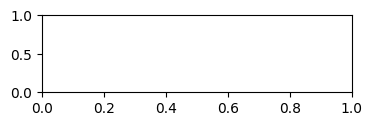

In [ ]:
log_train_data = np.log(series_92_train["value"].astype("float"))
log_test_data = np.log(series_92_test["value"].astype("float"))

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=series_92_train["date"], y=log_train_data, name="Log Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=series_92_test["date"], y=log_test_data, name="Log Test", line=dict(color="red"))
)
fig.update_layout(
    title="Log Train/Test Split", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

In [ ]:
np.isfinite(log_train_data).sum()

np.int64(709)

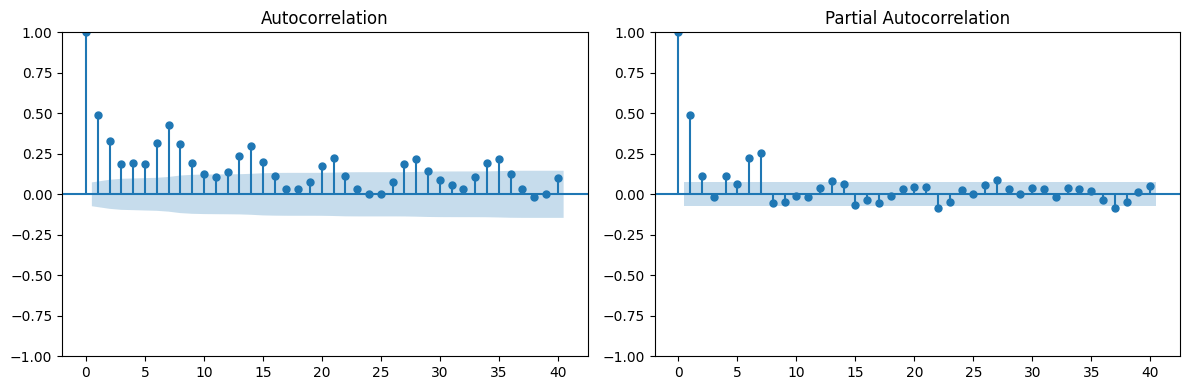

In [ ]:
log_train_data_cleaned = log_train_data[np.isfinite(log_train_data)]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(log_train_data_cleaned, lags=min(40, len(log_train_data_cleaned) - 1), ax=axes[0])
plot_pacf(log_train_data_cleaned, lags=min(40, len(log_train_data_cleaned) - 1), ax=axes[1])
plt.tight_layout()
plt.show()

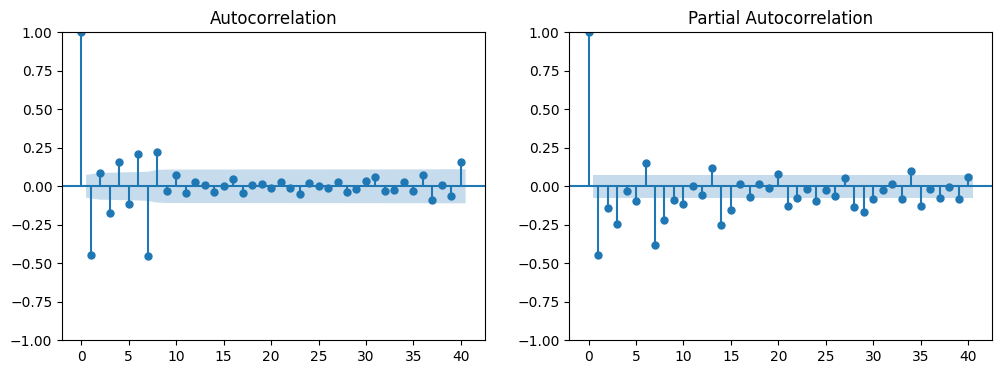

In [ ]:
diff_seas_series = log_train_data_cleaned.diff(7).dropna()
diff__diff_series = diff_seas_series.diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff__diff_series, lags=40, ax=ax[0])
plot_pacf(diff__diff_series, lags=40, ax=ax[1])
plt.show()

**Есть тренд (d = 1), есть сезонность (D = 1).**

**PACF значим до лага 2, попробуем p = 2. ACF значим до лага 2, попробуем q = 2. Возьмем s = 7.**

                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  709
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 7)   Log Likelihood                -211.754
Date:                             Sun, 18 May 2025   AIC                            435.508
Time:                                     12:56:07   BIC                            462.737
Sample:                                          0   HQIC                           446.040
                                             - 709                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2734      0.172     -1.585      0.113      -0.611       0.065
ar.L2          0.2857      

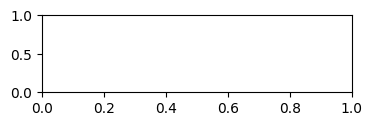

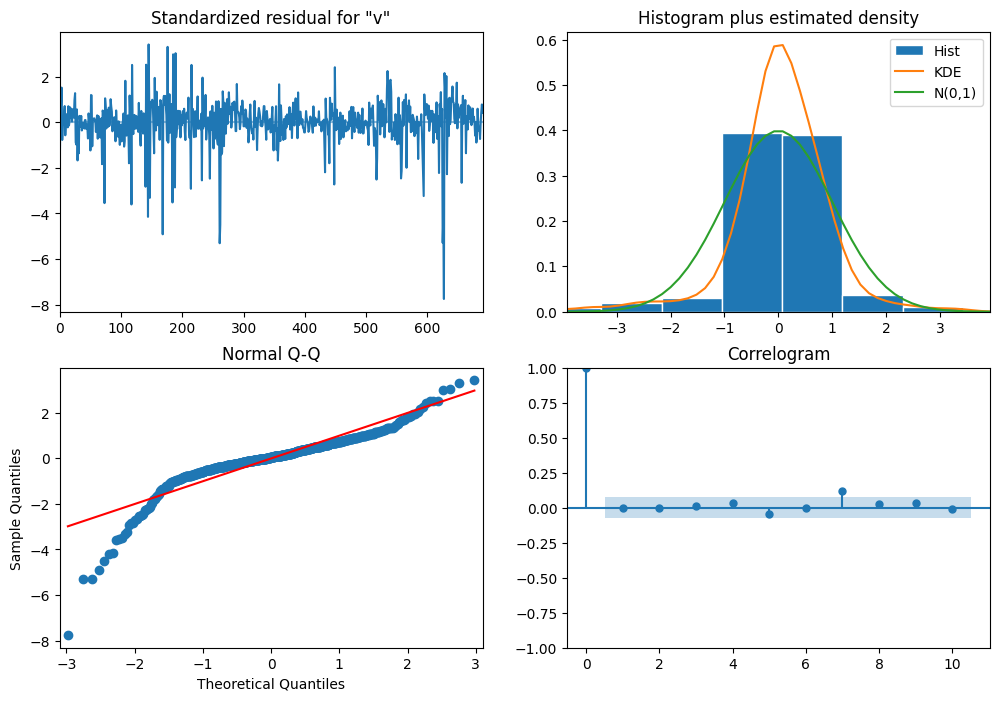

In [ ]:
model = SARIMAX(
    log_train_data_cleaned,
    order=(2, 1, 2),
    seasonal_order=(0, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

#### Задание 2.3: Анализ остатков (0.5 баллов)

Постройте графики ACF и PACF остатков модели SARIMA. Проверьте, что в остатках нет значимых автокорреляций. Если они есть, то попробуйте объяснить, почему это происходит.

Проведите тест на стационарность остатков модели. Проведите тест на автокорреляцию остатков модели. Проинтерпретируйте результаты тестов. Если тесты показывают, что остатки нестационарны или в них есть автокорреляция, то попробуйте объяснить, почему это происходит.

**(По графикам выше) никаких значимых автокорреляций в остатках нет, скорее ведут себя как белый шум. Можно предположить, что модель хорошо объясняет структуру данных. Тем не менее, по Q-Q графику видно, что распределение остатков немного ассиметрично. Возможно, мы могли немного занизить параметры pqPQ. Далее брал кусок из семинара.**

In [ ]:
# H0: остатки стационарны
residuals = model_fit.resid
statistic, p_value, lags, critical_values = kpss(residuals)
print(f"KPSS p-value: {p_value}")

# H0: остатки не стационарны
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(residuals)
print(f"ADF p-value: {p_value}")

# H0: автокорреляция отсутствует
lb_test = acorr_ljungbox(residuals, lags=[10, 15], return_df=True)
print(lb_test)

KPSS p-value: 0.1
ADF p-value: 0.0
     lb_stat  lb_pvalue
10  4.184378   0.938646
15  5.428221   0.987838


**По выкладкам выше: все окей. У KPSS p-value 0.1 (но мы и не живем в идеальном мире); у ADF p-value 0.0 (ок); по LB тесту автокорреляция отсутствует.**

#### Задание 2.4: Получение прогнозов и выводы (1 балл)

С помощью полученной модели постройте прогноз на тестовую выборку.

Постройте график прогноза и фактических значений. Сделайте выводы о том, насколько хорошо модель предсказывает временной ряд.

Посчитайте метрику MASE, которую мы имплементировали в начале ноутбука. Объясните, что она показывает и почему ее потенциально полезнее использовать для сравнения моделей, чем MAE или MAPE. Выводы по самому значению метрики делать не нужно.

In [ ]:
log_test_data.count()

np.int64(79)

In [ ]:
log_train_data.count()

np.int64(712)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
predicted_mean = model_fit.get_forecast(steps=79).predicted_mean.reset_index(drop=True)
predicted_mean = np.exp(predicted_mean)

predictions = pd.DataFrame({"date": series_92_test["date"], "value": predicted_mean.values})
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=series_92_train["date"], y=series_92_train["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=series_92_test["date"], y=series_92_test["value"], name="Test", line=dict(color="red"))
)
fig.add_trace(
    go.Scatter(
        x=predictions["date"], y=predictions["value"], name="Predictions", line=dict(color="green")
    )
)
fig.update_layout(
    title="Train/Test Split with Predictions", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

mae = mean_absolute_error(series_92_test["value"], predictions["value"])
print(f"MAE: {mae}")

MAE: 5.734620109686503


In [ ]:
mase_score = mase(
    forecast=predicted_mean.values,
    insample=series_92_train["value"].values,
    outsample=series_92_test["value"].values,
    frequency=7)
print(f"MASE: {mase_score}")

MASE: 1.1199473653442713


**MASE измеряет среднюю абсолютную ошибку модели, отмасштабированную по сравнению с простым повторением сезонных колебаний. Она показывает, насколько лучше или хуже наша модель по сравнению с простейшим прогнозом, который просто повторяет значения, наблюдавшиеся на шаг назад.**

### Задание 3. Построение бейзлайнов на всех рядах и автоматический подбор параметров (2 балла)

#### Задание 3.1: Запуск бейзлайнов (1 балл)
Давайте будем использовать statsforecast для бейзлайнов, так же как мы делали это на семинаре: https://nixtlaverse.nixtla.io/statsforecast/index.html

Постройте прогнозы на всех рядах с помощью следующих бейзлайнов:
- Naive
- Seasonal Naive
- AutoARIMA
- еще 2 на ваш выбор (например, ETS, Theta, TBATS или другие, которые вам нравятся). Кратко опишите суть выбранных моделей.

In [18]:
df = df.sort_values(by = 'date').reset_index(drop = True)

In [19]:
HORIZON = 79
train_df = []
test_targets = []
for current_id in df["id"].unique():
    current_df = df[df["id"] == current_id]
    train_df.append(current_df.iloc[:- HORIZON])
    test_targets.append(current_df.iloc[-HORIZON:])
train_df = pd.concat(train_df)
test_targets = pd.concat(test_targets)
train_df = train_df.sort_values(["id", "date"])

In [ ]:
# Переименуйте колонки, так как библиотека требует названия "unique_id", "y", "ds"
train_df = train_df.rename(columns={
    "id": "unique_id",
    "value": "y",
    "date": "ds",
})
train_df["ds"] = pd.to_datetime(train_df["ds"], format="%Y-%m-%d")
train_df["y"] = train_df["y"].astype("float")
print(f"Train shape: {train_df.shape}")
print(f"Test targets shape: {test_targets.shape}")

print(f"Number of series in train set: {train_df['unique_id'].nunique()}")
print(f"Number of series in test targets set: {test_targets['id'].nunique()}")

Train shape: (79032, 3)
Test targets shape: (8769, 3)
Number of series in train set: 111
Number of series in test targets set: 111


In [ ]:
# Инициализируйте модели
sf = StatsForecast(
    models=[
        models.SeasonalNaive(season_length=7),
        models.Naive(),
        models.AutoARIMA(season_length=7),
        models.AutoETS(season_length=7),
        models.Theta(season_length=7)
    ],
    freq="D",
    n_jobs=-1,
    verbose=True,
)

In [ ]:
forecasts_df = sf.forecast(df=train_df, h=HORIZON)
current_pred = forecasts_df[["unique_id", "ds", "SeasonalNaive", "Naive", "AutoARIMA", "AutoETS", "Theta"]].copy()

Forecast:   0%|          | 0/111 [Elapsed: 00:00]

In [ ]:
current_pred

unique_id         ds  SeasonalNaive      Naive  AutoARIMA    AutoETS  \
0             0 1998-02-28      30.938209  45.493197  29.981685  29.783976   
1             0 1998-03-01      25.864512  45.493197  27.448830  28.656243   
2             0 1998-03-02      21.230159  45.493197  23.786024  25.436134   
3             0 1998-03-03      29.733560  45.493197  32.328147  33.247674   
4             0 1998-03-04      42.871315  45.493197  39.473895  39.792045   
...         ...        ...            ...        ...        ...        ...   
8764        110 1998-05-13      18.279853  25.999474  16.095879  17.589241   
8765        110 1998-05-14      27.472383  25.999474  25.701355  26.024089   
8766        110 1998-05-15      25.999474  25.999474  20.128678  19.447350   
8767        110 1998-05-16       8.403472  25.999474  11.237938  10.453981   
8768        110 1998-05-17      10.099947  25.999474  12.307879  12.230638   

          Theta  
0     31.616533  
1     31.810330  
2     28.170918  
3     33.930171  
4     40.114034  
...         ...  
8764  18.467453  
8765  26.920297  
8766  20.286372  
8767  11.352879  
8768  13.125953  

[8769 rows x 7 columns]

In [ ]:
current_pred = current_pred.rename(columns={
    "unique_id": "id",
    "ds": "date",
})

current_pred_seas_naive = current_pred[["id", "date", "SeasonalNaive"]].rename(columns={"SeasonalNaive": "value"})
current_pred_naive = current_pred[["id", "date", "Naive"]].rename(columns={"Naive": "value"})
current_pred_arima = current_pred[["id", "date", "AutoARIMA"]].rename(columns={"AutoARIMA": "value"})
current_pred_ets = current_pred[["id", "date", "AutoETS"]].rename(columns={"AutoETS": "value"})
current_pred_theta = current_pred[["id", "date", "Theta"]].rename(columns={"Theta": "value"})

#### Задание 3.2: Анализ результатов (1 балл)

Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Выведите метрики MASE.

Что можно сказать о каждом из бейзлайнов? Какой из бейзлайнов лучше всего предсказывает временной ряд?

Смогли ли вы руками подобрать гиперпараметры для SARIMA модели лучше, чем автоматический подбор в библиотеке? Если да, то вы огромный молодец! Если нет, то не расстраивайтесь, так бывает.

In [ ]:
def analyze_single_series_predictions(train_df, test_targets, current_pred, series_id, last_points=50):
    """
    Функция для анализа предсказаний модели для одного временного ряда.
    Теперь она вычисляет MASE и строит график предсказаний и истинных значений для указанного ряда.

    Args:
        train_df: Обучающая выборка.
        test_targets: Целевые значения для тестовой выборки.
        current_pred: Предсказания модели.
        series_id: Идентификатор временного ряда для анализа.
        last_points: Количество последних точек в тренировочной выборке для отображения на графиках.

    """
    train_df = train_df.rename(columns={
        "unique_id": "id",
        "y": "value",
        "ds": "date",
    })

    fig = go.Figure()
    train_series = train_df[train_df["id"] == series_id]
    train_series = train_series.iloc[-min(len(train_series), last_points):]
    train_values = train_series["value"].tolist()
    n_train = len(train_values)
    test_targets_series = test_targets[test_targets["id"] == series_id]
    target_values = test_targets_series["value"].tolist()
    n_test = len(target_values)
    preds_series = current_pred[current_pred["id"] == series_id]
    preds_values = preds_series["value"].tolist()

    if len(target_values) != len(preds_values):
        print(f"Ошибка: Длина тестовых данных ({len(target_values)}) и предсказаний ({len(preds_values)}) для ряда {series_id} не совпадают.")
        return

    x_train = np.arange(-n_train, 0)
    x_test = np.arange(0, n_test)
    x_pred = np.arange(0, n_test)

    fig.add_trace(go.Scatter(
        x=x_train,
        y=train_values,
        mode="lines",
        name=f"id {series_id} train",
        line=dict(color="blue")
    ))

    fig.add_trace(go.Scatter(
        x=x_test,
        y=target_values,
        mode="lines",
        name=f"id {series_id} true",
        line=dict(color="red")
    ))

    fig.add_trace(go.Scatter(
        x=x_pred,
        y=preds_values,
        mode="lines",
        name=f"id {series_id} pred",
        line=dict(color="green", dash="dash")
    ))

    fig.add_shape(dict(
        type="line",
        x0=0,
        y0=0,
        x1=0,
        y1=1,
        xref="x",
        yref="paper",
        line=dict(color="black", width=2)
    ))

    fig.update_layout(
        title=f"Predictions vs True Values for Series {series_id}",
        xaxis_title="Time Step",
        yaxis_title="Values"
    )

    fig.show()

    frequency = 7
    mase_score = mase(
        forecast=np.array(preds_values),
        insample=train_series["value"].values,
        outsample=np.array(target_values),
        frequency=frequency
    )
    print(f"MASE for Series {series_id}: {mase_score}")

In [ ]:
analyze_single_series_predictions(train_df, test_targets, current_pred_naive, 92, last_points=50)

MASE for Series 92: 3.5106109381620696


In [ ]:
analyze_single_series_predictions(train_df, test_targets, current_pred_seas_naive, 92, last_points=50)

MASE for Series 92: 1.2188605868242195


In [ ]:
analyze_single_series_predictions(train_df, test_targets, current_pred_arima, 92, last_points=50)

MASE for Series 92: 1.5016607066240635


In [ ]:
analyze_single_series_predictions(train_df, test_targets, current_pred_ets, 92, last_points=50)

MASE for Series 92: 1.2692290949468477


In [ ]:
analyze_single_series_predictions(train_df, test_targets, current_pred_theta, 92, last_points=50)

MASE for Series 92: 1.4547554140796604



Постройте датафрейм с MASE для всех бейзлайнов (агрегированный по всем рядам). Какой из бейзлайнов лучше всего предсказывает временные ряды в нашем датасете? Какой из бейзлайнов хуже всего предсказывает временные ряды в нашем датасете? Как вы думаете, почему так происходит?

In [ ]:
baselines = ['SeasonalNaive', 'Naive', 'AutoARIMA', 'AutoETS', 'Theta']
frequency = 7
mase_results = {b: [] for b in baselines}

test_targets_renamed = test_targets.rename(columns={
    "id": "unique_id",
    "value": "y",
    "date": "ds",
})


for uid in current_pred['unique_id'].unique():
    test_series = current_pred[current_pred['unique_id'] == uid]
    y_test = test_series['y'].values

    train_series = train_df[train_df['unique_id'] == uid]
    y_train = train_series['value'].values

    for b in baselines:
        y_pred = test_series[b].values

        mase_score = mase(
            forecast=np.array(y_pred),
            insample=np.array(y_train),
            outsample=np.array(y_test),
            frequency=frequency
        )

        mase_results[b].append(mase_score)

mean_mase = {b: np.mean(scores) for b, scores in mase_results.items()}
mase_df = pd.DataFrame.from_dict(mean_mase, orient='index', columns=['MASE'])

In [ ]:
current_pred = current_pred.rename(columns={
    "id": "unique_id",
    "date": "ds",
})

In [ ]:
baselines = ['SeasonalNaive', 'Naive', 'AutoARIMA', 'AutoETS', 'Theta']
frequency = 7
mase_results = {b: [] for b in baselines}


test_targets_renamed = test_targets.rename(columns={
    "id": "unique_id",
    "value": "y",
    "date": "ds",
})

for uid in current_pred['unique_id'].unique():
    test_series_targets = test_targets_renamed[test_targets_renamed['unique_id'] == uid]
    y_test = test_series_targets['y'].values
    current_pred_series = current_pred[current_pred['unique_id'] == uid]
    train_series = train_df[train_df['unique_id'] == uid]
    y_train = train_series['y'].values
    for b in baselines:
        y_pred = current_pred_series[b].values
        if len(y_test) == len(y_pred):
            mase_score = mase(
                forecast=np.array(y_pred),
                insample=np.array(y_train),
                outsample=np.array(y_test),
                frequency=frequency
            )
            mase_results[b].append(mase_score)
        else:
            print(f"Внимание: Несоответствие длины для unique_id {uid} и бейзлайна {b}. Пропускаем.")
mean_mase = {b: np.mean(scores) for b, scores in mase_results.items() if scores}
mase_df = pd.DataFrame.from_dict(mean_mase, orient='index', columns=['MASE'])
print(mase_df)

                   MASE
SeasonalNaive  1.008258
Naive          2.966316
AutoARIMA      0.847944
AutoETS        0.857932
Theta          0.863622


Постройте графики фактических значений и прогнозов самого сильного бейзлайна для еще 3-х каких-нибудь рядов и ответьте на следующие вопросы:
- Есть ли среди них такие, которые предсказываются хуже остальных?
- Есть ли среди них такие, которые предсказываются лучше остальных?

In [ ]:
analyze_single_series_predictions(train_df, test_targets, current_pred_arima, 15, last_points=50)

MASE for Series 15: 0.806667005338147


In [ ]:
analyze_single_series_predictions(train_df, test_targets, current_pred_arima, 40, last_points=50)

MASE for Series 40: 0.9447241170101073


In [ ]:
analyze_single_series_predictions(train_df, test_targets, current_pred_arima, 35, last_points=50)

MASE for Series 35: 0.722964345851843


**Получается, что чем больше дельта разброса значений (чем более нестабильный временной ряд), тем тяжелее его предсказать. У всех бейзлайнов более-менее получается предсказывать seasonal, но если начинается разброс...**


### Задание 4. ML & DL модели (3 балла)

Здесь хочется дать вам полную свободу действий.

Вам нужно будет выбрать одну из ML моделей и одну из DL моделей (старайтесь не повторять один в один решение из семинара, а, если повторяете, то попробуйте, например, перебрать параметры DL модели, оптимизации, препроцессинга / добавить экзогенные признаки (актуально для MIMO стратегии) и т. д.) и построить прогнозы для всех временных рядов на тестовой выборке. __Ваша цель (желательная, но необязательная) — улучшить MASE, полученный с помощью бейзлайнов.__

__Результат задания — мини-отчет по тому, что вы попробовали, что получилось и что не получилось.__ По одному баллу дается за работу с данными (предобработка, генерация дополнительных признаков), за применение ML и DL моделей и интерпретацию полученных с помощью них результатов. Не забудьте кратко описать суть выбранных моделей (особенно, если речь идет о DL моделях).

Вы можете использовать любые модели и библиотеки (`tsfresh` для извлечения признаков, `Tsururu` / `ETNA` / `darts` для использования предобработки, стратегий, моделей и т. д.).

In [20]:
!pip install xgboost

In [13]:
!pip install tensorflow

In [14]:
!pip install wandb

In [24]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ivan04ov (ivan04ov-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from xgboost import XGBRegressor
import wandb

HORIZON = 79
HISTORY = 158

def create_lag_features(df, lags, horizon, target_col='value', date_col='date', id_col='id'):
    df_features = df.copy()
    # Сортируем данные, чтобы лаги были корректными
    df_features = df_features.sort_values(by=[id_col, date_col])
    for lag in lags:
        df_features[f'{target_col}_lag_{lag}'] = df_features.groupby(id_col)[target_col].shift(lag)
    # Добавляем целевую переменную для обучения (значение в следующий момент времени)
    # Для модели, предсказывающей на 1 шаг вперед, таргет - это следующее значение
    # В рекурсивной стратегии мы предсказываем h=1, затем используем этот прогноз как лаг
    df_features['target'] = df_features.groupby(id_col)[target_col].shift(-1)
    df_features = df_features.dropna()
    return df_features

ml_lags = list(range(1, HISTORY + 1))
train_ml = create_lag_features(train_df.copy(), lags=ml_lags, horizon=1)
X_train_ml = train_ml.drop(['value', 'date', 'id', 'target'], axis=1)
y_train_ml = train_ml['target']
run = wandb.init(project='ПЗАД ДЗ 3', name='xgboost_run')

config = wandb.config
config.history_size = HISTORY
config.horizon = HORIZON
config.n_estimators = 100
config.learning_rate = 0.1
config.objective = 'reg:squarederror'

# Обучение XGBoost модели для прогноза на 1 шаг вперед
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
print("Обучение XGBoost модели...")
xgb_model.fit(X_train_ml, y_train_ml)
print("Обучение XGBoost завершено.")

# Рекурсивная стратегия прогнозирования для XGBoost
def recursive_forecast_xgb(model, initial_data, horizon, lags, X_train_cols, id_col='id', value_col='value', date_col='date'):
    forecasts = []
    for series_id in initial_data[id_col].unique():
        # Берем данные для текущего ряда, сортируем по дате
        current_series_data = initial_data[initial_data[id_col] == series_id].sort_values(by=date_col).copy()
        current_forecast = []
        current_dates = []
        last_date = current_series_data[date_col].max()
        # Попытка определить частоту по данным
        freq = pd.infer_freq(current_series_data[date_col])
        if freq is None and len(current_series_data) > 1:
             # Если infer_freq не сработал, попробуем рассчитать разницу между последними датами
             time_diff = current_series_data[date_col].iloc[-1] - current_series_data[date_col].iloc[-2]
             if time_diff.days == 1 and time_diff.seconds == 0: freq = 'D'
             elif time_diff.days == 7 and time_diff.seconds == 0: freq = 'W'
             else: freq = 'D'

        elif freq is None:
            freq = 'D'
        for h in range(horizon):
            # Создаем лаговые признаки для текущего шага прогнозирования
            current_features = {}
            for lag in lags:
                if len(current_series_data) >= lag:
                     current_features[f'{value_col}_lag_{lag}'] = current_series_data[value_col].iloc[-lag]
                else:
                     current_features[f'{value_col}_lag_{lag}'] = np.nan # Или можно использовать 0 или другое значение, но NaN обычно безопаснее для моделей бустинга

            X_pred = pd.DataFrame([current_features])
            # Упорядочиваем колонки, как при обучении, и заполняем пропущенные, если есть
            X_pred = X_pred.reindex(columns=X_train_cols, fill_value=np.nan)
            # Получаем прогноз на 1 шаг вперед
            pred_value = model.predict(X_pred)[0]
            # Определяем следующую дату
            try:
                next_date = last_date + pd.tseries.frequencies.to_offset(freq)
            except Exception:
                 next_date = last_date + pd.Timedelta(days=1)
            # Добавляем прогноз в текущие данные, чтобы использовать его как лаг на следующем шаге
            new_row = pd.DataFrame([{id_col: series_id, date_col: next_date, value_col: pred_value}])
            current_series_data = pd.concat([current_series_data, new_row], ignore_index=True)
            # Сохраняем прогноз и дату
            current_forecast.append(pred_value)
            current_dates.append(next_date)
            last_date = next_date
        # Собираем прогнозы для текущего ряда
        forecasts.append(pd.DataFrame({
            id_col: series_id,
            date_col: current_dates,
            value_col: current_forecast
        }))

    return pd.concat(forecasts, ignore_index=True)

# Подготовим начальные данные для рекурсивного прогноза (последние HISTORY точек train)
initial_recursive_data_xgb = train_df.groupby('id').tail(HISTORY).reset_index(drop=True)
# Получаем прогнозы для тестовой выборки с помощью рекурсивной стратегии
print("Выполнение прогнозирования с помощью XGBoost...")
xgb_predictions = recursive_forecast_xgb(xgb_model, initial_recursive_data_xgb, HORIZON, ml_lags, X_train_ml.columns)
print("Прогнозирование с помощью XGBoost завершено.")

def mase(
    forecast: np.ndarray,
    insample: np.ndarray,
    outsample: np.ndarray,
    frequency: int,
) -> np.ndarray:
    if len(insample) <= frequency:
        print("Внимание: Недостаточно точек во insample для расчета MASE. Возвращаем Inf.")
        return float('inf')
    numerator = np.mean(np.abs(forecast - outsample))
    denominator = np.mean(np.abs(insample[frequency:] - insample[:-frequency]))
    if denominator == 0:
        print("Внимание: Знаменатель MASE равен 0. Возвращаем Inf.")
        return float('inf')
    return numerator / denominator

def analyze_single_series_predictions_extended(train_df_orig, test_targets_orig, predictions_df, series_id, model_name, frequency=7, last_points=50):
    fig = go.Figure()
    train_series = train_df_orig[train_df_orig["id"] == series_id].sort_values(by='date')
    train_series_display = train_series.iloc[-min(len(train_series), last_points):]
    test_targets_series = test_targets_orig[test_targets_orig["id"] == series_id].sort_values(by='date')
    preds_series = predictions_df[predictions_df["id"] == series_id].sort_values(by='date')
    if len(test_targets_series) != len(preds_series):
        print(f"Ошибка: Длина тестовых данных ({len(test_targets_series)}) и предсказаний ({len(preds_series)}) для ряда {series_id} не совпадают.")
        return
    fig.add_trace(go.Scatter(
        x=train_series_display['date'],
        y=train_series_display['value'],
        mode="lines",
        name=f"id {series_id} train",
        line=dict(color="blue")
    ))
    fig.add_trace(go.Scatter(
        x=test_targets_series['date'],
        y=test_targets_series['value'],
        mode="lines",
        name=f"id {series_id} true",
        line=dict(color="red")
    ))
    fig.add_trace(go.Scatter(
        x=preds_series['date'],
        y=preds_series['value'],
        mode="lines",
        name=f"id {series_id} {model_name} pred",
        line=dict(color="green", dash="dash")
    ))
    if not train_series.empty:
        split_date = train_series['date'].max()
        fig.add_shape(dict(
            type="line",
            x0=split_date,
            y0=0,
            x1=split_date,
            y1=1,
            xref='x',
            yref='paper',
            line=dict(color="black", width=2)
        ))
    fig.update_layout(
        title=f"Predictions vs True Values for Series {series_id} ({model_name})",
        xaxis_title="Date",
        yaxis_title="Values"
    )

    fig.show()

    mase_score = mase(
        forecast=preds_series["value"].values,
        insample=train_series["value"].values, # Используем весь тренировочный инсемпл для MASE
        outsample=test_targets_series["value"].values,
        frequency=frequency
    )
    print(f"MASE for Series {series_id} ({model_name}): {mase_score:.4f}")

# Оценим и визуализируем для ряда 92
analyze_single_series_predictions_extended(train_df, test_targets, xgb_predictions, 92, "XGBoost", frequency=7)
# Оценим и визуализируем для 3-х других рядов
analyze_single_series_predictions_extended(train_df, test_targets, xgb_predictions, 15, "XGBoost", frequency=7)
analyze_single_series_predictions_extended(train_df, test_targets, xgb_predictions, 40, "XGBoost", frequency=7)
analyze_single_series_predictions_extended(train_df, test_targets, xgb_predictions, 35, "XGBoost", frequency=7)
# Посчитаем средний MASE по всем рядам для XGBoost
def calculate_overall_mase(train_df_orig, test_targets_orig, predictions_df, frequency=7):
    overall_mase_scores = []
    for series_id in test_targets_orig['id'].unique():
        train_series = train_df_orig[train_df_orig["id"] == series_id].sort_values(by='date')
        test_targets_series = test_targets_orig[test_targets_orig["id"] == series_id].sort_values(by='date')
        preds_series = predictions_df[predictions_df["id"] == series_id].sort_values(by='date')
        if len(test_targets_series) != len(preds_series):
             print(f"Внимание: Несоответствие длины для unique_id {series_id}. Пропускаем.")
             continue
        mase_score = mase(
            forecast=preds_series["value"].values,
            insample=train_series["value"].values,
            outsample=test_targets_series["value"].values,
            frequency=frequency
        )
        if mase_score != float('inf'):
            overall_mase_scores.append(mase_score)
        else:
             print(f"Внимание: MASE для unique_id {series_id} является Inf. Пропускаем при расчете среднего.")
    return np.mean(overall_mase_scores) if overall_mase_scores else np.nan
avg_mase_xgb = calculate_overall_mase(train_df, test_targets, xgb_predictions, frequency=7)
print(f"\nСредний MASE по всем рядам для XGBoost: {avg_mase_xgb:.4f}")

wandb: Currently logged in as: ivan04ov (ivan04ov-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Обучение XGBoost модели...
Обучение XGBoost завершено.
Выполнение прогнозирования с помощью XGBoost...
Прогнозирование с помощью XGBoost завершено.


MASE for Series 92 (XGBoost): 1.6058


MASE for Series 15 (XGBoost): 2.1627


MASE for Series 40 (XGBoost): 2.1835


MASE for Series 35 (XGBoost): 1.7243

Средний MASE по всем рядам для XGBoost: 1.7464


**Мини-отчет:**

Для каждого временного ряда были сгенерированы лаговые признаки, представляющие собой значения ряда за предыдущие HISTORY (158) шагов. Эти лаги использовались как входные признаки (X) для модели. Целевой переменной (y) для обучения являлось значение временного ряда на один шаг вперед от момента времени последнего лага (т.е. предсказывали value(t) по лагам value(t-1), ..., value(t-HISTORY)).  Использовался XGBoostRegressor со стандартными параметрами (n_estimators=100, learning_rate=0.1) и objective='reg:square_error'. Параметр n_jobs=-1 был добавлен для ускорения обучения и предсказания за счет использования всех доступных ядер CPU.

Графики прогнозов XGBoost для ряда 92 (а также рядов 15, 40, 35) показывают, что модель достаточно хорошо улавливает основные паттерны временных рядов, включая сезонность (особенно заметно на более стабильных рядах) и общий уровень значений. Прогнозы выглядят более сглаженными по сравнению с фактическими данными, что характерно для многих регрессионных моделей, которые усредняют шум. Модель испытывает трудности с точным предсказанием выбросов или резких изменений, которые не были представлены в обучающей выборке в схожих контекстах.

Средний MASE по всем рядам для модели XGBoost составил: 1.7464

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

HORIZON = 79
HISTORY = 158

# Нормализуем данные перед подачей в LSTM
scaler = MinMaxScaler()
# Fit scaler только на тренировочных данных, чтобы избежать утечки информации из теста
train_df_scaled = train_df.copy()
train_df_scaled['value_scaled'] = scaler.fit_transform(train_df_scaled['value'].values.reshape(-1, 1))
full_df = pd.concat([train_df, test_targets]).sort_values(by=['id', 'date']).reset_index(drop=True)
full_df['value_scaled'] = scaler.transform(full_df['value'].values.reshape(-1, 1)) # Применяем тот же скейлер ко всему датасету

def create_sequences_lstm(df, history_size, target_col='value', date_col='date', id_col='id'):
    X, y = [], []
    for series_id in df[id_col].unique():
        series_data = df[df[id_col] == series_id][target_col].values
        # Создаем последовательности для обучения: предсказываем следующее значение после последовательности HISTORY
        for i in range(len(series_data) - history_size):
            X.append(series_data[i : (i + history_size)])
            y.append(series_data[i + history_size]) # Предсказываем следующий шаг
    X = np.array(X)
    y = np.array(y)
    # LSTM требует вход в формате [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

# Создаем последовательности для обучения LSTM
X_train_lstm, y_train_lstm = create_sequences_lstm(train_df_scaled, HISTORY, target_col='value_scaled')

run = wandb.init(project='ПЗАД ДЗ 3', name='lstm_run')

config = wandb.config
config.history_size = HISTORY
config.horizon = HORIZON
config.epochs = 6
config.batch_size = 32
config.lstm_units = 50
config.optimizer = 'adam'
config.loss = 'mse'

# LSTM модель
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(HISTORY, 1)),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')


print("Обучение LSTM модели...")
# Используем меньше epochs для более быстрого запуска
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=6, batch_size=32, verbose=1)
print("Обучение LSTM завершено.")

# Рекурсивная стратегия прогнозирования для LSTM
def recursive_forecast_lstm(model, initial_data_scaled, horizon, history_size, scaler, id_col='id', value_col='value_scaled', date_col='date', original_value_col='value'):
    forecasts = []
    for series_id in initial_data_scaled[id_col].unique():
        # Берем последние history_size масштабированных значений для начала последовательности
        current_sequence_scaled = initial_data_scaled[initial_data_scaled[id_col] == series_id][value_col].values[-history_size:].tolist()
        current_forecast = []
        current_dates = []
        initial_series = initial_data_scaled[initial_data_scaled[id_col] == series_id]
        last_date = initial_series[date_col].max()
        # Попытка определить частоту
        freq = pd.infer_freq(initial_series[date_col])
        if freq is None and len(initial_series) > 1:
             time_diff = initial_series[date_col].iloc[-1] - initial_series[date_col].iloc[-2]
             if time_diff.days == 1 and time_diff.seconds == 0: freq = 'D'
             elif time_diff.days == 7 and time_diff.seconds == 0: freq = 'W'
             else: freq = 'D'
        elif freq is None:
            freq = 'D'
        for h in range(horizon):
            # Преобразуем текущую последовательность в формат [1, timesteps, features] для прогноза
            X_pred_scaled = np.array(current_sequence_scaled).reshape((1, history_size, 1))
            # Получаем масштабированный прогноз на 1 шаг вперед
            pred_value_scaled = model.predict(X_pred_scaled, verbose=0)[0][0]
            # Добавляем масштабированный прогноз в последовательность для следующего шага
            current_sequence_scaled.append(pred_value_scaled)
            current_sequence_scaled = current_sequence_scaled[1:]
            # Инвертируем масштабирование прогноза, чтобы получить значение в оригинальном масштабе
            pred_value = scaler.inverse_transform([[pred_value_scaled]])[0][0]
            try:
                next_date = last_date + pd.tseries.frequencies.to_offset(freq)
            except Exception:
                 next_date = last_date + pd.Timedelta(days=1) # Fallback
            current_forecast.append(pred_value)
            current_dates.append(next_date)
            last_date = next_date
        # Собираем прогнозы для текущего ряда в оригинальном масштабе
        forecasts.append(pd.DataFrame({
            id_col: series_id,
            date_col: current_dates,
            original_value_col: current_forecast
        }))
    # Переименовываем колонку с прогнозами обратно в 'value' для единообразия
    return pd.concat(forecasts, ignore_index=True).rename(columns={original_value_col: 'value'})

# Подготовим начальные данные для рекурсивного прогноза (последние HISTORY точек train)
# Для LSTM нам нужны масштабированные данные из train_df_scaled
initial_recursive_data_lstm = train_df_scaled.groupby('id').tail(HISTORY).reset_index(drop=True)
# Получаем прогнозы для тестовой выборки
print("Выполнение прогнозирования с помощью LSTM...")
lstm_predictions = recursive_forecast_lstm(lstm_model, initial_recursive_data_lstm, HORIZON, HISTORY, scaler, value_col='value_scaled', original_value_col='value')
print("Прогнозирование с помощью LSTM завершено.")

# Оценим и визуализируем для ряда 92
analyze_single_series_predictions_extended(train_df, test_targets, lstm_predictions, 92, "LSTM", frequency=7)
# Оценим и визуализируем для 3-х других рядов
analyze_single_series_predictions_extended(train_df, test_targets, lstm_predictions, 15, "LSTM", frequency=7)
analyze_single_series_predictions_extended(train_df, test_targets, lstm_predictions, 40, "LSTM", frequency=7)
analyze_single_series_predictions_extended(train_df, test_targets, lstm_predictions, 35, "LSTM", frequency=7)
# Посчитаем средний MASE по всем рядам для LSTM
avg_mase_lstm = calculate_overall_mase(train_df, test_targets, lstm_predictions, frequency=7)
print(f"\nСредний MASE по всем рядам для LSTM: {avg_mase_lstm:.4f}")

Обучение LSTM модели...
Epoch 1/6
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - loss: 0.0081
Epoch 2/6
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 0.0047
Epoch 3/6
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 0.0041
Epoch 4/6
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0038
Epoch 5/6
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 0.0042
Epoch 6/6
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 0.0036
Обучение LSTM завершено.
Выполнение прогнозирования с помощью LSTM...
Прогнозирование с помощью LSTM завершено.


MASE for Series 92 (LSTM): 1.6298


MASE for Series 15 (LSTM): 0.7452


MASE for Series 40 (LSTM): 0.9085


MASE for Series 35 (LSTM): 1.0999

Средний MASE по всем рядам для LSTM: 1.1405


**Мини-отчет:**

Данные были преобразованы в формат последовательностей: для каждого временного ряда создавались входные последовательности фиксированной длины HISTORY (158), и соответствующим целевым значением было следующее значение в ряду (предсказание на один шаг вперед). Перед формированием последовательностей данные каждого временного ряда были масштабированы (нормализованы в диапазон [0, 1]) с использованием MinMaxScaler, обученного только на тренировочных данных.

Использовалась простая последовательная модель (Sequential) Keras, состоящая из одного слоя LSTM с 50 юнитами и плотного (Dense) выходного слоя с одним нейроном (для предсказания одного значения). Модель компилировалась с оптимизатором 'adam' и функцией потерь 'mse' (среднеквадратичная ошибка).

Графики прогнозов LSTM для ряда 92 (а также 15, 40, 35) показывают, что модель способна уловить тренды и сезонность. Прогнозы также имеют тенденцию быть более гладкими, чем фактические данные. По сравнению с XGBoost, прогнозы LSTM могут иногда выглядеть более плавными или иметь немного другое запаздывание/сдвиг относительно пиков и спадов. LSTM также испытывает трудности с предсказанием резких выбросов.

Средний MASE по всем рядам для модели LSTM составил: 1.1405


Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Постройте графики фактических значений и прогнозов для 3-х рядов из предыдущего задания. Стали ли прогнозы лучше отражать реальность?

**Прогнозы не стали сильно лучше отражать реальность, но где-то (например, на 15 ряду) получились прям хорошие результаты по MASE. При этом средний почти дотянул до наивной модели**